# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
# using SQLite Table to read data.
con = sqlite3.connect('gdrive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [11]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [15]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


1    336824
0     57107
Name: Score, dtype: int64

## Taking a Sample of 100k datapoints 

In [19]:
final = final.sample(100000)#sample of 100k points
final.shape

(100000, 10)

In [20]:
final = final.sort_values('Time',ascending=True)#sorting them by time for time series cross validation
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
149769,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...
149767,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...
374334,374335,B00004CI84,A3L5V40F14R2GP,AARON,0,0,1,1004054400,Beetlejuice! Beetlejuice! Beatlejuice!,Winona Ryder is HOT! HOT! HOT! as the gothic d...
361316,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,1,1010275200,A little piece of heaven.,For years I have been trying to simulate a tru...
374419,374420,B00004CI84,A1ZH086GZYL5MZ,Doug DeBolt,2,2,1,1013385600,"A little gross, a lot of fun",Michael Keaton was already on his way to being...
479729,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,1,1022112000,Way To Go Guys!,I'm never dissapointed with the great gadgets ...
374417,374418,B00004CI84,A2E1UPR4LZJSF2,Ashley,2,2,1,1023235200,Beetlejuice! Beetlejuice! Beetlejuice!,What can I say? This is a CLASSIC! I've seen t...
149699,149700,B00006L2ZT,A19JWUIRF6DXLV,Andrew J Monzon,2,4,1,1036800000,My favorite American Band!,I have been a huge fan of CVB ever since a fri...
374335,374336,B00004CI84,API663PFYRQCP,Donn Hart,66,67,1,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [21]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
This is a good snack to carry in a purse for when I need a quick snack.  It is high protein and low sugar which is good for my diabetes requirements.  Also it is easy to eat because of its small size.  I like the zip lock bag so that I can eat two or three and close up the bag.  I am always looking for quick and easy snacks for my diet requirements.  This hits the target and also hits the taste spot, too!
I have a large German Shepherd who is a bone a Holic. These hings are big and meatty and massive. He goes through th esmall bone 5 - 7 inches in 2 days. These take him a week! Great deal all around!
I bought this product for my Husband. He was recently diagnosed as being gluten intolerant. My husband made them for the and my daughter(3.5 yrs old )on a recent mom's n

In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.
This is a good snack to carry in a purse for when I need a quick snack.  It is high protein and low sugar which is good for my diabetes requirements.  Also it is easy to eat because of its small size.  I like the zip lock bag so that I can eat two or three and close up the bag.  I am always looking for quick and easy snacks for my diet requirements.  This hits the target and also hits the taste spot, too!
I have a large German Shepherd who is a bone a Holic. These hings are big and meatty and massive. He goes through th esmall bone 5 - 7 inches in 2 days. These take him a week! Great deal all around!
I bought this product for my Husband. He was recently diagnosed as being gluten intolerant. My husband made them for the and my daughter(3.5 yrs old )on a recent mom's n

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have a large German Shepherd who is a bone a Holic. These hings are big and meatty and massive. He goes through th esmall bone 5 - 7 inches in 2 days. These take him a week! Great deal all around!


In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have a large German Shepherd who is a bone a Holic These hings are big and meatty and massive He goes through th esmall bone 5 7 inches in 2 days These take him a week Great deal all around 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:45<00:00, 2180.54it/s]


In [0]:
#loading pickle for saving and retreiving files
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [31]:
preprocessed_reviews[1500]

'large german shepherd bone holic hings big meatty massive goes th esmall bone inches days take week great deal around'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [33]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size=0.3)
#splitting the dataset 

print('Size of train dataset is:',len(X_train))#size of training dataset 
print('Size of the test dataset is:',len(X_test))#size of test dataset


Size of train dataset is: 70000
Size of the test dataset is: 30000


In [34]:
from sklearn.model_selection import TimeSeriesSplit#importing for time series split
tscv = TimeSeriesSplit(n_splits=5)#time series split for the data
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test se


In [35]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print('train data shape:',train.shape,'test data shape',cv.shape)

train data shape: (6370,) test data shape (6363,)
train data shape: (12733,) test data shape (6363,)
train data shape: (19096,) test data shape (6363,)
train data shape: (25459,) test data shape (6363,)
train data shape: (31822,) test data shape (6363,)
train data shape: (38185,) test data shape (6363,)
train data shape: (44548,) test data shape (6363,)
train data shape: (50911,) test data shape (6363,)
train data shape: (57274,) test data shape (6363,)
train data shape: (63637,) test data shape (6363,)


# BOW FACTORIZATION

In [71]:
vect = CountVectorizer()#initiating the vectorizer

vect.fit(X_train)#fitting data into vectorizer makes it learn all the vocablury

#transforming the data into training and test dataset
train_set = vect.transform(X_train)
test_set = vect.transform(X_test)

print('AFTER VECTORIZATION:')
print(train_set.shape)
print(test_set.shape)
print('Some of the feature names are:',vect.get_feature_names()[:10:-1])


AFTER VECTORIZATION:
(70000, 50860)
(30000, 50860)
Some of the feature names are: ['zzzzz', 'zzz', 'zzigae', 'zz', 'zymox', 'zym', 'zylotol', 'zylitol', 'zyje', 'zy', 'zx', 'zweiback', 'zveet', 'zupreem', 'zuppa', 'zupas', 'zumba', 'zuma', 'zulu', 'zukes', 'zuke', 'zucker', 'zuchon', 'zuchinni', 'zuccini', 'zucchini', 'zuc', 'zsweet', 'zp', 'zours', 'zotz', 'zots', 'zorushi', 'zorroz', 'zoot', 'zooms', 'zooming', 'zoom', 'zoological', 'zoo', 'zonker', 'zone', 'zon', 'zomg', 'zombies', 'zombie', 'zola', 'zoka', 'zojurushi', 'zojirushi', 'zoji', 'zoey', 'zoe', 'zocor', 'znaturalfoods', 'zn', 'ziyad', 'ziwipeak', 'ziwi', 'ziva', 'zits', 'zitis', 'ziti', 'zita', 'ziptop', 'zips', 'zippy', 'zippo', 'zipping', 'zippfizz', 'zippers', 'zippered', 'zipper', 'zipped', 'zippable', 'zipp', 'ziplok', 'ziplocs', 'ziplocks', 'ziplocked', 'ziplock', 'ziploc', 'zipfizz', 'zip', 'zinzinnati', 'zingy', 'zinging', 'zingiber', 'zingers', 'zingerman', 'zinger', 'zing', 'zinfandelic', 'zinfandel', 'zinc', 'z

In [0]:
savetofile(train_set,'train_set_bow')
savetofile(test_set,'test_set_bow')

In [0]:
train_set_bow = openfromfile('train_set_bow')
test_set_bow = openfromfile('test_set_bow')

## Applying the Decision Tree model with GridSearch Cross Validation using time series split

In [75]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
max_depth = [1,5,10,50,100,500]
min_samples_split = [5,10,100,500]

tscv = TimeSeriesSplit(n_splits = 5)#using timeseries split for cross validation

params = {'max_depth': max_depth,'min_samples_split':min_samples_split} #fitting the parameters for grid search
model = (RandomizedSearchCV(DecisionTreeClassifier(criterion = 'gini'),param_distributions = params,cv=tscv,verbose = 1,scoring='roc_auc',return_train_score=True))

model.fit(train_set_bow,Y_train)
#fitting data in model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
  

In [0]:
savetofile(model,'model_bow')#saving the model

In [0]:
model_bow = openfromfile('model_bow')#retreiving the model

In [0]:

# as we have two hyperaparameters to tune so we will plot heatmap and to show hyperparameters giving maximum AUC score
def plots(model):#function for plotting heatmaps
    
    print('Best Hyperparameters are:',model.best_params_)
    df = pd.DataFrame(model.cv_results_)#saving into the dataframe
    results = df.groupby(['param_min_samples_split','param_max_depth']).min().unstack()[['mean_test_score',
                                                                                              'mean_train_score']]
    results = results.fillna(0)
    sns.set(font_scale = 1.2)
    fig, ax = plt.subplots(figsize=(20,10))#setting the font size
    plt.subplot(2,2,1)
    title_test = 'AUC score on test set VS max_depth, min_samples_split'
    fmt = 'png'
    sns.heatmap(results.mean_test_score, annot=True, fmt='.4g');#heatmap for test score
    plt.title(title_test);
    #plt.savefig('{title_test}.{fmt}', format=fmt, dpi=300);

    plt.subplot(2,2,2)
    title_train = 'AUC score on train set VS max_depth, min_samples_split'
    fmt = 'png'
    sns.heatmap(results.mean_train_score, annot=True, fmt='.4g');#heatmap for train score
    plt.title(title_train);
    #plt.savefig('{title_train}.{fmt}', format=fmt, dpi=300);
    

Best Hyperparameters are: {'min_samples_split': 500, 'max_depth': 50}


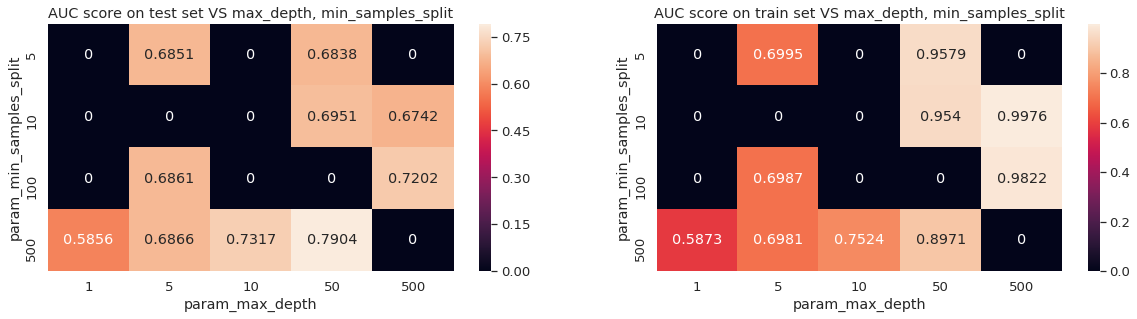

In [79]:
plots(model_bow)

In [0]:
#initiating the optimal classifier 
best_depth_bow = model_bow.best_params_['max_depth']
best_splits_bow = model_bow.best_params_['min_samples_split']

# AUC ON TEST DATA AND ROC

In [0]:
#initiating the optimal classifier after fitting the right hyperparameters

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#1.Function for calculating the test and train Area under curve after fitting with right hyperparameters
def auc(depth,splits,train_set,test_set):
    tree_optimal = DecisionTreeClassifier(criterion = 'gini',max_depth = depth,min_samples_split = splits)
    tree_optimal.fit(train_set,Y_train)
    pred_tr = tree_optimal.predict(train_set)# predicting all the classes for test dataset for confusion matrix
    pred_test = tree_optimal.predict(test_set)#predicting all the classes for train dataset for confusin matrix
    
    train_pred_proba = tree_optimal.predict_proba(train_set)[:,1]
    test_pred_proba = tree_optimal.predict_proba(test_set)[:,1]
    #predict_proba gives the probability of a particular data point belonging to the specified class

    train_auc = roc_auc_score(Y_train,train_pred_proba)
    test_auc = roc_auc_score(Y_test,test_pred_proba)
    print('AUC on train data is:',train_auc)
    print('AUC on test data is:',test_auc)
    print("******************************************************\n")
    return train_auc,test_auc,train_pred_proba,test_pred_proba,pred_tr,pred_test

#*******************************************************************************************************************************    

#2.Function for plotting the roc curve
def curve(train_pred,test_pred ):
    fpr_tr, tpr_tr, _ = roc_curve(Y_train,train_pred)
    fpr_test, tpr_test, _ = roc_curve(Y_test,test_pred)
#calculating the fpr,tpr and thresholds for each training and test dataset
    auc_train = roc_auc_score(Y_train,train_pred)
    auc_test = roc_auc_score(Y_test, test_pred)
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,8))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")#this plots the roc curve for AUC = 0.5
    plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
    plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
    plt.xlabel('False positive rate(1-specificity)',fontsize=18)
    plt.ylabel('True positive rate(sensitivity)',fontsize=18)
    plt.title('Reciever operating characteristics curve',fontsize=18)
    plt.legend(loc='best')
    plt.show()
    print('**************************************\n')

#********************************************************************************************************************************

#3.Function for calculating F1,precision and recall
def metrics(pred):
    # calculating the precison score
    print('precison score is {}'.format(precision_score(Y_test,pred)))
    #calculating the recall score 
    print('\nrecall_score is {}'.format(recall_score(Y_test,pred)))
    #calculating the f1 score
    print('\nf1 score is {}\n'.format(f1_score(Y_test,pred)))
    print("****************************************************************\n")
    
#********************************************************************************************************************************

#4.Function for plotting the confusion matrix
def c_matrix(pred_train,pred_test):
    train_matrix = pd.DataFrame(confusion_matrix(Y_train,pred_train),range(2),range(2))# svaing the output to dataframe for train_data
    print('training data\n')
    print(train_matrix.head())
    print('*****************************************')
    print('test data\n')
    test_matrix = pd.DataFrame(confusion_matrix(Y_test,pred_test),range(2),range(2))# svaing the output to dataframe for test_data
    print(test_matrix.head())
    print('So we need to visualize this dataframe in a heatmap for confusin matrix')
    sns.set(font_scale = 1.2)
    fig, ax = plt.subplots(figsize=(13,13))#setting the font size
    plt.subplot(2,2,1)
    plt.title('for training data')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    sns.heatmap(train_matrix,annot = True,fmt = 'g',cmap = 'viridis')
    #annot = True writes data values in each cell
    # fmt is string formatting code which is to be used when adding annonations
    # cmap is the mapping from data values to color space
    plt.subplot(2,2,2)
    plt.title('for test data')
    sns.heatmap(test_matrix,annot = True,fmt = 'g',cmap = 'viridis')

#***************************************************************************************************************************** 
def imp_features(depth,splits,train_set,vectorizer):
    tree_optimal = DecisionTreeClassifier(criterion = 'gini',max_depth = depth,min_samples_split = splits)
    tree_optimal.fit(train_set,Y_train)
    features = tree_optimal.feature_importances_
    indices = np.argsort(features)[::-1]
    feature_names = vectorizer.get_feature_names()
    print('TOP 20 important features which gives maximum information gain on splitting are:\n')
    for i in (indices[0:20]):
        print("%s\t -->\t%f  "%(feature_names[i],features[i]))
    

AUC on train data is: 0.8919820055989595
AUC on test data is: 0.8174546574911161
******************************************************



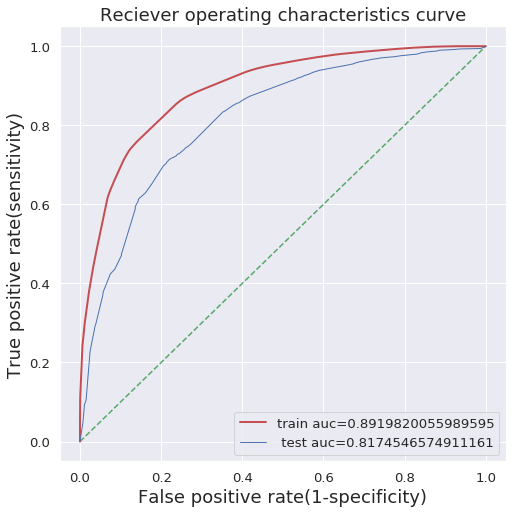

**************************************

precison score is 0.8960405055913744

recall_score is 0.95507842832738

f1 score is 0.9246180157492153

****************************************************************

training data

      0      1
0  4482   5706
1  1899  57913
*****************************************
test data

      0      1
0  1390   2854
1  1157  24599
So we need to visualize this dataframe in a heatmap for confusin matrix


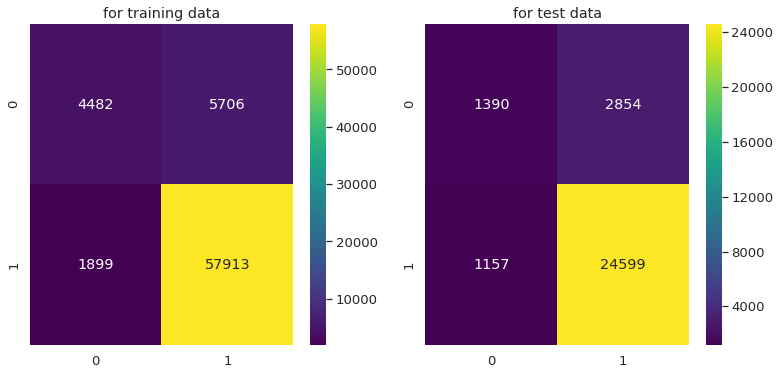

In [83]:
'''AUC ON TEST DATA'''
train_auc_BOW,test_auc_BOW,train_pred_proba_BOW,test_pred_proba_BOW,train_pred,test_pred = auc(best_depth_bow,best_splits_bow,train_set_bow,test_set_bow)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba_BOW,test_pred_proba_BOW)

'''Precision,recall and f1 score'''
metrics(test_pred)

'''Plotting the confusion matrix'''
c_matrix(train_pred,test_pred)


In [84]:
'''FEATURESgiving maximum information gain on splitting'''
imp_features(best_depth_bow,best_splits_bow,train_set_bow,vect)

TOP 20 important features which gives maximum information gain on splitting are:

not	 -->	0.069818  
great	 -->	0.055936  
money	 -->	0.041588  
disappointed	 -->	0.040012  
worst	 -->	0.036491  
return	 -->	0.028950  
terrible	 -->	0.027084  
best	 -->	0.025884  
horrible	 -->	0.025477  
awful	 -->	0.024152  
waste	 -->	0.023214  
love	 -->	0.020638  
good	 -->	0.019222  
delicious	 -->	0.016954  
threw	 -->	0.015517  
disappointing	 -->	0.012214  
disappointment	 -->	0.011849  
loves	 -->	0.010536  
refund	 -->	0.010487  
perfect	 -->	0.009966  


In [86]:
pip install six

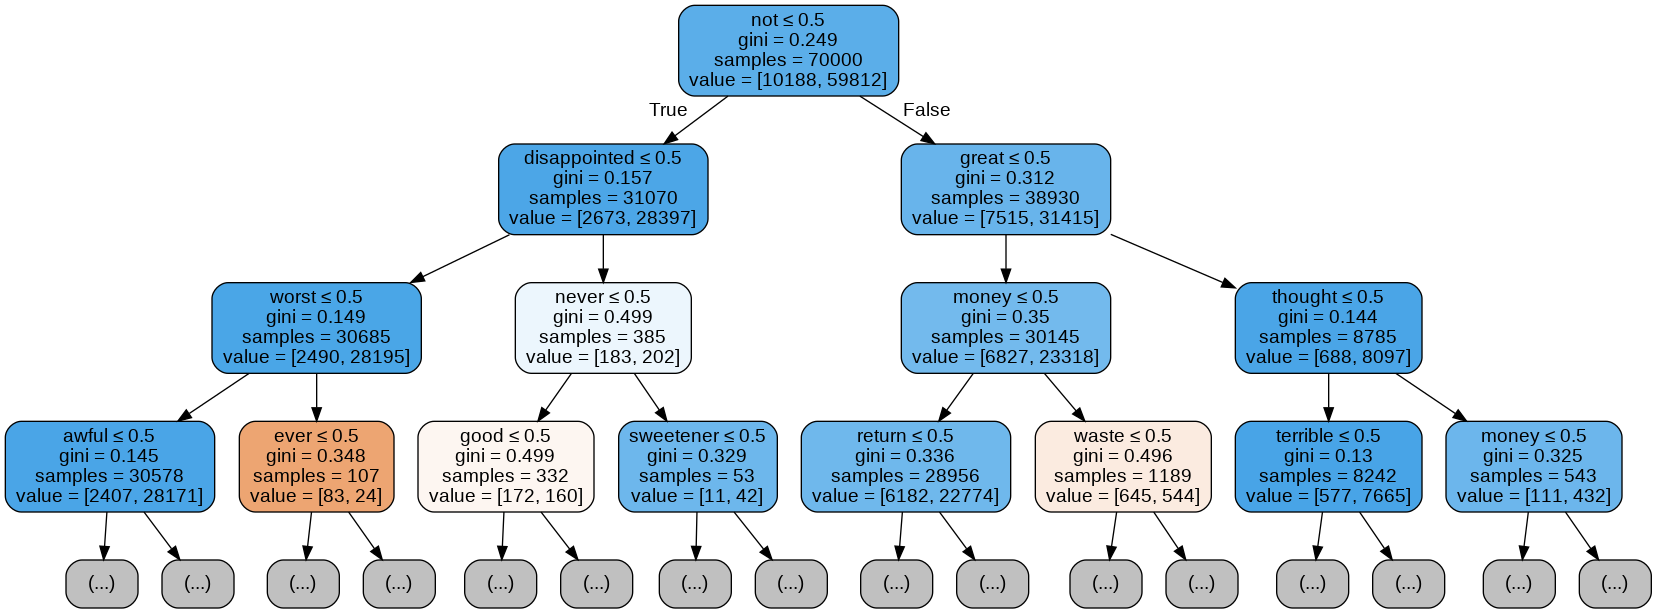

In [93]:
#visualization using graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


dtree_bow = DecisionTreeClassifier()
dtree_bow.fit(train_set_bow,Y_train)


dot_data = StringIO()

export_graphviz(dtree_bow, out_file=dot_data,max_depth=3,feature_names = vect.get_feature_names(),
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



# <font color='red'> TFIDF FEATURIZATION</font>

In [94]:
tfidf_vect  = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
#min_df signifies minimum number of times a word must occur in corpus for consideration
#ngram_range tells about the unigram and bigram
tfidf_vect.fit(X_train)
train_set = tfidf_vect.transform(X_train)
test_set = tfidf_vect.transform(X_test)

print('after vectorization training set:',train_set.shape)
print('after vectorization test set:',test_set.shape)


after vectorization training set: (70000, 41068)
after vectorization test set: (30000, 41068)


In [0]:
savetofile(train_set,'train_tfidf')#saving to file for future use
savetofile(test_set,'test_tfidf')

In [0]:
train_set_tfidf = openfromfile('train_tfidf')
test_set_tfidf = openfromfile('test_tfidf')

In [97]:
print('some of the feature names are',tfidf_vect.get_feature_names()[:1000])

some of the feature names are ['aa', 'aback', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy', 'able chew', 'able continue', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able handle', 'able keep', 'able locate', 'able make', 'able obtain', 'able open', 'able order', 'able pick', 'able purchase', 'able put', 'able return', 'able save', 'able see', 'able stop', 'able take', 'able taste', 'able tell', 'able tolerate', 'able try', 'able use', 'abroad', 'absence', 'absent', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely amazing', 'absolutely awesome', 'absolutely awful', 'absolutely best', 'absolutely delicious', 'absolutely disgusting', 'absolutely fabulous', 'absolutely fantastic', 'absolutely favorite', 'absolutely great', 'absolutely horrible', 'absolutely love', 'absolutely loved', 'absolutely loves', 'absolutely no', 'absolutely not', 'absolutely nothing', 'absolutely nuts', 'absolute

# DECISION TREES WITH RANDOMIZED SEARCH CROSS VALIDATION

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
max_depth = [1,5,10,50,100,500]
min_samples_split = [5,10,100,500]

tscv = TimeSeriesSplit(n_splits = 5)#using timeseries split for cross validation

params = {'max_depth': max_depth,'min_samples_split':min_samples_split} #fitting the parameters for grid search
model = RandomizedSearchCV(DecisionTreeClassifier(criterion = 'gini'),param_distributions = params,cv=tscv,verbose = 1,scoring='roc_auc',return_train_score = True)
model.fit(train_set_tfidf,Y_train)
#fitting data in model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.8min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
  

In [0]:
savetofile(model,'model_tfidf')

In [0]:
model_tfidf = openfromfile('model_tfidf')

Best Hyperparameters are: {'min_samples_split': 500, 'max_depth': 500}


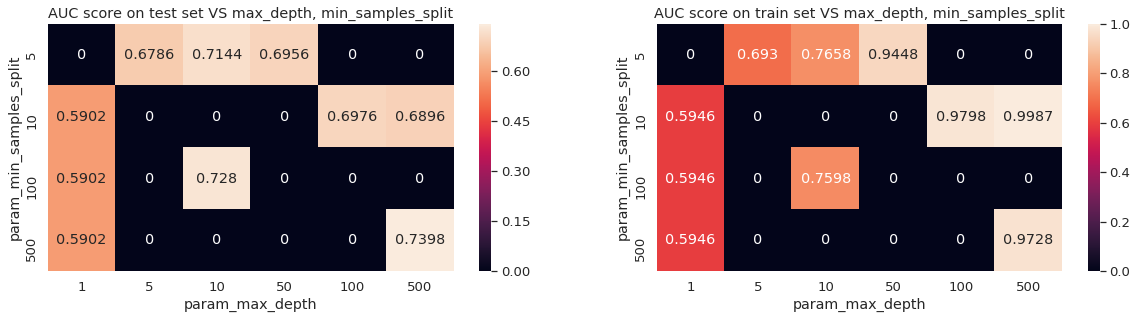

In [102]:
plots(model_tfidf)

In [0]:
best_depth_tfidf = model_tfidf.best_params_['max_depth']
best_split_tfidf = model_tfidf.best_params_['min_samples_split']

AUC on train data is: 0.97197880311588
AUC on test data is: 0.7626005155465363
******************************************************



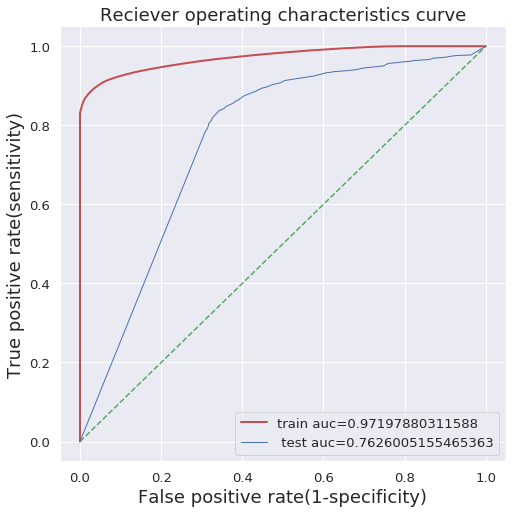

**************************************

precison score is 0.9174283136547288

recall_score is 0.9080602578040068

f1 score is 0.9127202481999649

****************************************************************

training data

      0      1
0  8169   2019
1  3183  56629
*****************************************
test data

      0      1
0  2139   2105
1  2368  23388
So we need to visualize this dataframe in a heatmap for confusin matrix


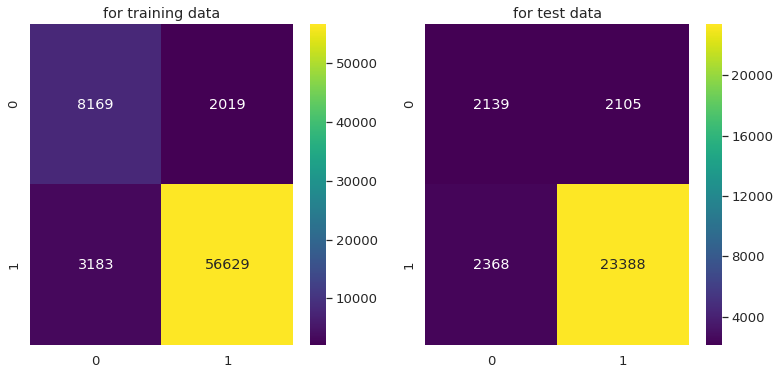

In [104]:
'''AUC ON TEST DATA'''
train_auc_tfidf,test_auc_tfidf,train_pred_proba_tfidf,test_pred_proba_tfidf,train_pred,test_pred = auc(best_depth_tfidf,
best_split_tfidf,train_set_tfidf,test_set_tfidf)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba_tfidf,test_pred_proba_tfidf)

'''Precision,recall and f1 score'''
metrics(test_pred)

'''Plotting the confusion matrix'''
c_matrix(train_pred,test_pred)


In [105]:
'''FEATURES giving maximum information gain on splitting'''
imp_features(best_depth_tfidf,best_split_tfidf,train_set_tfidf,tfidf_vect)

TOP 20 important features which gives maximum information gain on splitting are:

not	 -->	0.043087  
great	 -->	0.031781  
disappointed	 -->	0.024069  
worst	 -->	0.020271  
money	 -->	0.017950  
return	 -->	0.017744  
terrible	 -->	0.016167  
horrible	 -->	0.015832  
not buy	 -->	0.015831  
not recommend	 -->	0.015643  
waste money	 -->	0.015475  
awful	 -->	0.014649  
best	 -->	0.011524  
threw	 -->	0.010509  
refund	 -->	0.010413  
good	 -->	0.010187  
disgusting	 -->	0.009275  
delicious	 -->	0.008567  
love	 -->	0.007842  
disappointment	 -->	0.007443  


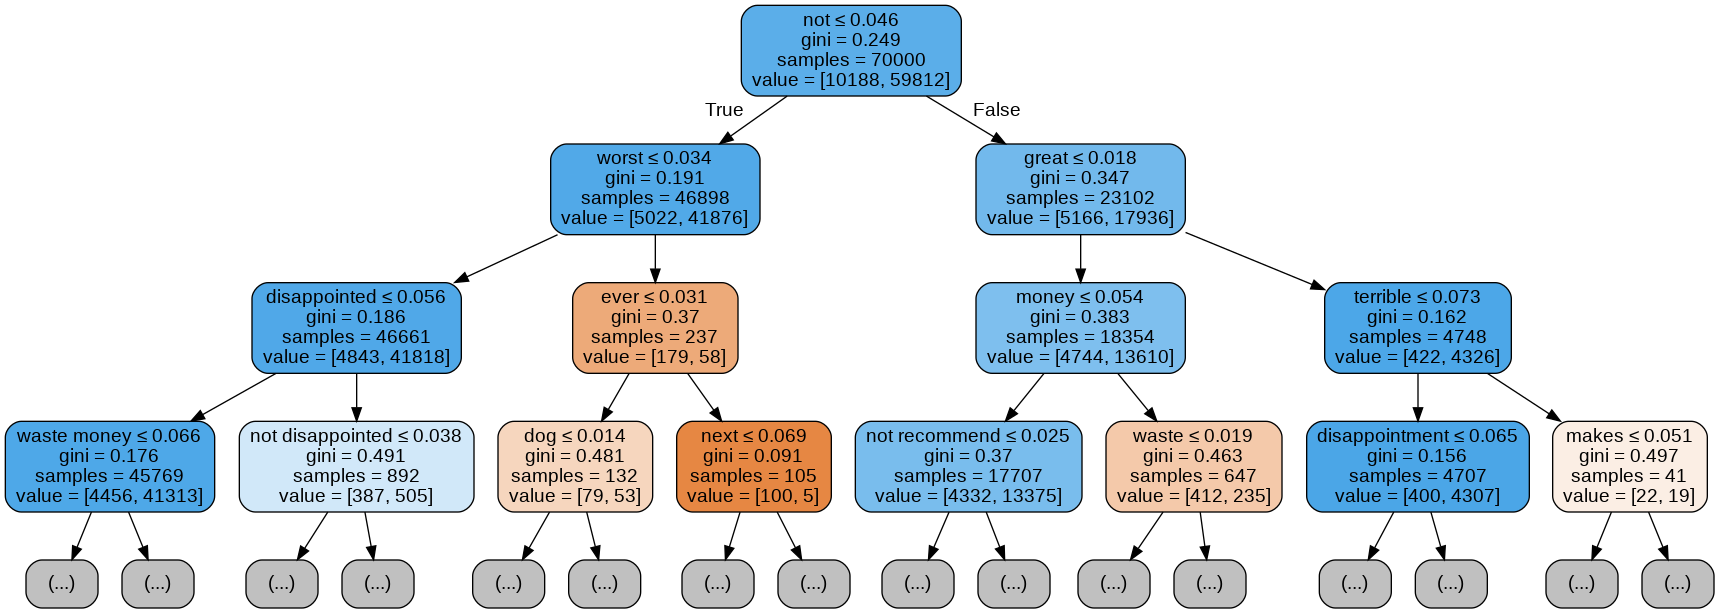

In [106]:
dtree_tfidf = DecisionTreeClassifier()
dtree_tfidf.fit(train_set_tfidf,Y_train)


dot_data = StringIO()

export_graphviz(dtree_tfidf, out_file=dot_data,max_depth=3,feature_names = tfidf_vect.get_feature_names(),
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


##  Applying WORD 2 VECTOR

In [0]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
#preparing the training data for  word to vector vectorization    
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
#preparing the test data for word to vector fatorization

In [43]:
# this line of code trains the w2v model on the give list of sentances   

w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)# min_count = 5 considers only words that occured atleast 5 times

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  16048


In [45]:
print('sample words :',w2v_words[0:50])

sample words : ['magnum', 'one', 'best', 'tasting', 'kona', 'blends', 'tried', 'medium', 'roast', 'close', 'perfection', 'delivers', 'smooth', 'brew', 'makes', 'think', 'drinking', 'percent', 'times', 'really', 'not', 'go', 'wrong', 'coffee', 'proflowers', 'sent', 'flowers', 'buyer', 'saying', 'persons', 'fault', 'left', 'finding', 'last', 'minute', 'mother', 'day', 'horrible', 'favorite', 'crackers', 'nutty', 'flavor', 'healthy', 'taste', 'wonderful', 'absolutely', 'anything', 'spread', 'friends', 'family']


# Average WORD 2 Vector

In [47]:
#computing average word to vector for training data 
train_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_set.append(sent_vec)

print(len(train_set))#number of data points

100%|██████████| 70000/70000 [02:29<00:00, 468.00it/s]


70000


In [0]:
savetofile(train_set,'train_avgw2v')

In [49]:
#computing average word to vector for test data 

test_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in s_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_set.append(sent_vec)

print(len(test_set))#number of datapoints in test set

30000


In [0]:
savetofile(test_set,'test_avgw2v')

 # Appplying Decision tree on Average Word to vector

In [0]:
train_set_avgw2v = openfromfile('train_avgw2v')
test_set_avgw2v = openfromfile('test_avgw2v')

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
max_depth = [1,5,10,50,100,500]
min_samples_split = [5,10,100,500]

tscv = TimeSeriesSplit(n_splits = 5)#using timeseries split for cross validation

params = {'max_depth': max_depth,'min_samples_split':min_samples_split} #fitting the parameters for grid search
model = RandomizedSearchCV(DecisionTreeClassifier(criterion = 'gini'),param_distributions = params,cv=tscv,verbose = 1,scoring='roc_auc',return_train_score=True)
model.fit(train_set_avgw2v,Y_train)
#fitting data in model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
  

In [0]:
savetofile(model,'model_avgw2v')

In [0]:
model_avgw2v = openfromfile('model_avgw2v')

Best Hyperparameters are: {'min_samples_split': 500, 'max_depth': 500}


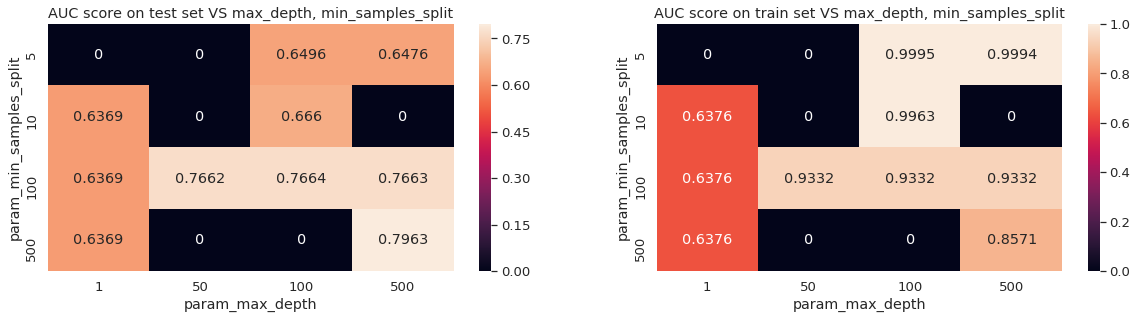

In [55]:
plots(model_avgw2v)

In [0]:
best_depth_avgw2v = model.best_params_['max_depth']
best_split_avgw2v = model.best_params_['min_samples_split']

AUC on train data is: 0.8727745788393739
AUC on test data is: 0.799561646937057
******************************************************



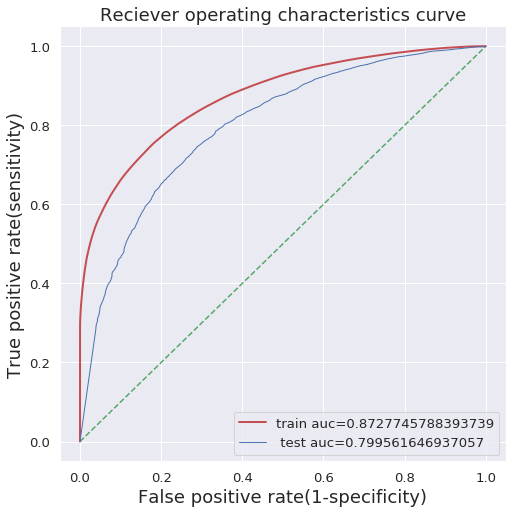

**************************************

precison score is 0.8889008775715724

recall_score is 0.9595822332660351

f1 score is 0.922890216579537

****************************************************************

training data

      0      1
0  3290   6898
1  1930  57882
*****************************************
test data

      0      1
0  1155   3089
1  1041  24715
So we need to visualize this dataframe in a heatmap for confusin matrix


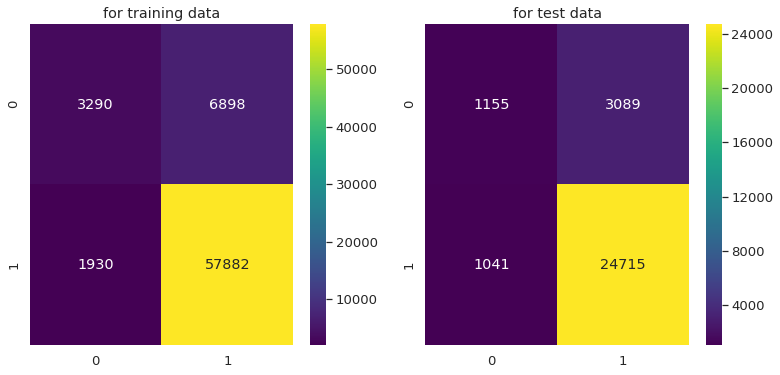

In [57]:
'''AUC ON TEST DATA'''
train_auc_avgw2v,test_auc_avgw2v,train_pred_proba_avgw2v,test_pred_proba_avgw2v,train_pred,test_pred = auc(best_depth_avgw2v,
best_split_avgw2v,train_set_avgw2v,test_set_avgw2v)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba_avgw2v,test_pred_proba_avgw2v)

'''Precision,recall and f1 score'''
metrics(test_pred)

'''Plotting the confusion matrix'''
c_matrix(train_pred,test_pred)


# TFIDF weighted WORD 2 VECTOR

In [0]:
vect = TfidfVectorizer()#initializing the tfidf vectorizer 

tf_idf = vect.fit_transform(X_train)#fitting the training data
dictionary = dict(zip(vect.get_feature_names(), list(vect.idf_)))#zipping both of the feature names and vectorizer idf scores

In [59]:
import itertools
dict(itertools.islice(dictionary.items(),20))
#printing first 20 elements of the dictionary

{'aa': 9.517207477028483,
 'aaa': 10.364505337415688,
 'aaaa': 10.769970445523851,
 'aaaaa': 11.057652517975633,
 'aaaaaaaaaaaaaaaaaaaargh': 11.463117626083797,
 'aaaaaaaaaaaaaaaaacccccccckkkkkk': 11.463117626083797,
 'aaaaaaaaagghh': 11.463117626083797,
 'aaaaaaah': 11.463117626083797,
 'aaaaaahhhhhyaaaaaa': 11.463117626083797,
 'aaaaah': 11.463117626083797,
 'aaaarrrrghh': 11.463117626083797,
 'aaah': 10.54682689420964,
 'aaahhhs': 11.463117626083797,
 'aachen': 11.463117626083797,
 'aadmit': 11.463117626083797,
 'aadults': 11.463117626083797,
 'aafco': 10.769970445523851,
 'aafes': 11.463117626083797,
 'aah': 11.463117626083797,
 'aahhed': 11.463117626083797}

In [60]:
tfidf_feat = vect.get_feature_names() # tfidf words/col-names
print(tfidf_feat[:20])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaahhhhhyaaaaaa', 'aaaaah', 'aaaarrrrghh', 'aaah', 'aaahhhs', 'aachen', 'aadmit', 'aadults', 'aafco', 'aafes', 'aah', 'aahhed']


In [61]:
train_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in training set is stored in this list
row=0;
for sent in tqdm(s_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_set_tfidfw2v.append(sent_vec)
    row += 1    
print(len(train_set_tfidfw2v))

100%|██████████| 70000/70000 [30:38<00:00, 38.07it/s]

70000


In [62]:
test_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in test set is stored in this list
row=0;
for sent in tqdm(s_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_set_tfidfw2v.append(sent_vec)
    row += 1
    
print(len(test_set_tfidfw2v))


100%|██████████| 30000/30000 [13:23<00:00, 36.27it/s]

30000


In [0]:
savetofile(train_set_tfidfw2v,'train_tfidfw2v')
savetofile(test_set_tfidfw2v,'test_tfidfw2v')

In [0]:
train_tfidfw2v = openfromfile('train_tfidfw2v')
test_tfidfw2v = openfromfile('test_tfidfw2v')

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
max_depth = [1,5,10,50,100,500]
min_samples_split = [5,10,100,500]

tscv = TimeSeriesSplit(n_splits = 5)#using timeseries split for cross validation

params = {'max_depth': max_depth,'min_samples_split':min_samples_split} #fitting the parameters for grid search
model = RandomizedSearchCV(DecisionTreeClassifier(criterion = 'gini'),param_distributions = params,cv=tscv,verbose = 1,scoring='roc_auc',return_train_score=True)
model.fit(train_set_tfidfw2v,Y_train)
#fitting data in model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
  

In [0]:
savetofile(model,'model_tfidfw2v')

In [0]:
model_tfidfw2v = openfromfile('model_tfidfw2v')

Best Hyperparameters are: {'min_samples_split': 500, 'max_depth': 50}


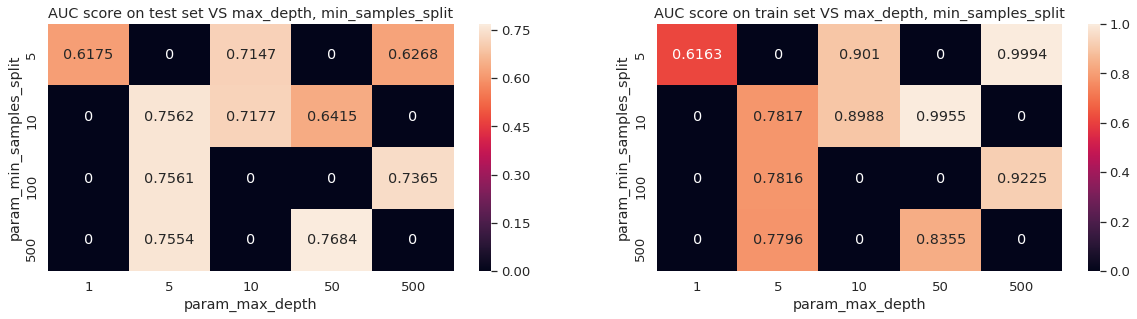

In [68]:
plots(model_tfidfw2v)

In [0]:
best_depth_tfidfw2v = model.best_params_['max_depth']
best_split_tfidfw2v = model.best_params_['min_samples_split']

AUC on train data is: 0.8499288962699536
AUC on test data is: 0.7714328965412961
******************************************************



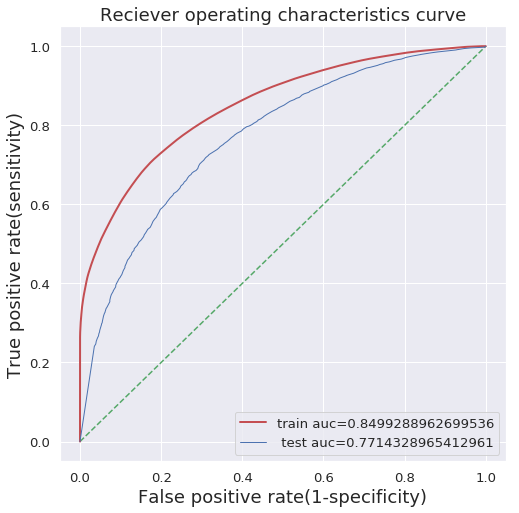

**************************************

precison score is 0.8811216010749267

recall_score is 0.9675027178133251

f1 score is 0.9222939837518737

****************************************************************

training data

      0      1
0  2598   7590
1  1568  58244
*****************************************
test data

     0      1
0  882   3362
1  837  24919
So we need to visualize this dataframe in a heatmap for confusin matrix


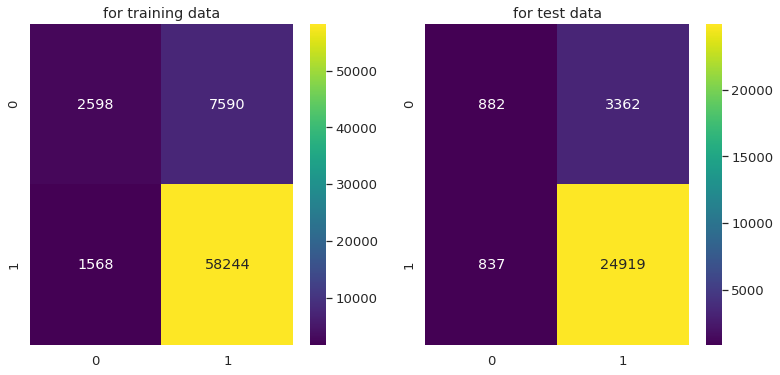

In [70]:
'''AUC ON TEST DATA'''
train_auc_tfidfw2v,test_auc_tfidfw2v,train_pred_proba_tfidfw2v,test_pred_proba_tfidfw2v,train_pred,test_pred = auc(best_depth_tfidfw2v,
best_split_tfidfw2v,train_set_tfidfw2v,test_set_tfidfw2v)

'''PLOTTING THE ROC CURVE'''
curve(train_pred_proba_tfidfw2v,test_pred_proba_tfidfw2v)

'''Precision,recall and f1 score'''
metrics(test_pred)

'''Plotting the confusion matrix'''
c_matrix(train_pred,test_pred)


# [6] Conclusions

In [107]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer' , 'max_depth' , 'min_samples_split' , 'AUC on test data']

x.add_row(['Bag of words' , best_depth_bow ,best_splits_bow,test_auc_BOW])

x.add_row(['TFIDF',best_depth_tfidf,best_split_tfidf,test_auc_tfidf])

x.add_row(['Avergae W2V',best_depth_avgw2v,best_split_avgw2v,test_auc_avgw2v])

x.add_row(['tfidf W2V',best_depth_tfidfw2v,best_split_tfidfw2v,test_auc_tfidfw2v])



print(x)


+--------------+-----------+-------------------+--------------------+
|  Vectorizer  | max_depth | min_samples_split |  AUC on test data  |
+--------------+-----------+-------------------+--------------------+
| Bag of words |     50    |        500        | 0.8174546574911161 |
|    TFIDF     |    500    |        500        | 0.7626005155465363 |
| Avergae W2V  |    500    |        500        | 0.799561646937057  |
|  tfidf W2V   |     50    |        500        | 0.7714328965412961 |
+--------------+-----------+-------------------+--------------------+
